In [3]:
#### This code cell is to limit GPU memory use because you'll be sharing GPU #### 
#### If you're using your own GPU, you can change the per_process_cpu_memory_fraction to 1.0 ####
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py' 

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

tar_gz_path = 'cifar-10-python.tar.gz'

if not isdir(cifar10_dataset_folder_path):
    if not isfile(tar_gz_path):
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
            urlretrieve(
                'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                tar_gz_path,
                pbar.hook)
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 6:
Image - Min Value: 7 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


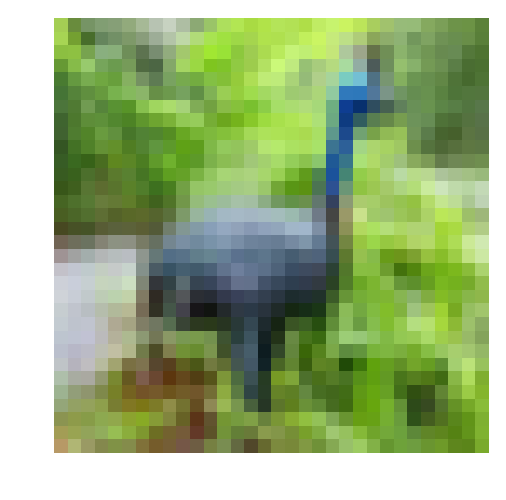

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 6
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [6]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    norm = (x-x.min())/(x.max()-x.min())
    return norm

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

Hint: Don't reinvent the wheel.

In [7]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    encoding = np.eye(10)[x]
    return encoding

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [10]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, [None] + list(image_shape), name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, [None ,n_classes], name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    
    return tf.placeholder(tf.float32, None, name="keep_prob")


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

In [11]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    X_shape = x_tensor.get_shape().as_list()
    C_kshape = list(conv_ksize + (X_shape[-1],) + (conv_num_outputs,))
    #print(C_kshape)
    #print(np.prod(C_kshape[:3]))
    #print(np.sqrt(2.0/np.prod(C_kshape[:3])))
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    # The shape of the filter bias is (output_depth,)
    F_W = tf.Variable(tf.truncated_normal(C_kshape,0.0,np.sqrt(2.0/np.prod(C_kshape[:3]))),dtype=np.float32)
    F_b = tf.Variable(tf.zeros(conv_num_outputs,dtype=np.float32))
    # The shape of the convolution stride is (batch_size, height, width, depth)
    C_strides = list((1,)+conv_strides+(1,))
    # The padding, either 'VALID' or 'SAME'.
    padding = 'SAME'
    conv_output = tf.nn.conv2d(x_tensor, F_W, C_strides, padding) + F_b
    conv_output = tf.layers.batch_normalization(inputs=conv_output, center=True, scale=True, training=True)
    conv_output = tf.nn.relu(conv_output)
    P_kshape = [1] + list(pool_ksize) + [1]
    P_stride = [1] + list(pool_strides) + [1]
    conv_output = tf.nn.max_pool(conv_output,P_kshape,P_stride,padding)
    return conv_output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [12]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    X_shape = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor,[-1,np.prod(X_shape[1:])])

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [13]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    X_shape = x_tensor.get_shape().as_list()
    shape = list((X_shape[-1],)+(num_outputs,))
    #print(shape)
    #print(shape[0])
    W = tf.Variable(tf.truncated_normal(shape,0.0,np.sqrt(2.0/np.prod(shape[0]))),dtype=np.float32)
    b = tf.Variable(tf.zeros(num_outputs,dtype=np.float32))
    fc_output = tf.tensordot(x_tensor,W,axes=([1], [0]))+b
    fc_output = tf.layers.batch_normalization(inputs=fc_output, center=True, scale=True, training=True)
    fc_output = tf.nn.relu(fc_output)
    return fc_output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


In [14]:
with tf.Session() as sess:
    a = tf.placeholder(tf.float32, None, name='a')
    b = tf.placeholder(tf.float32, None, name='b')
    c = tf.tensordot(a,b, axes=([1], [0]))
    print(sess.run(c, feed_dict={a:[[1,1],[2,2]], b:[[2,2],[1,1]]}))

[[ 3.  3.]
 [ 6.  6.]]


In [15]:
a=np.array([[1,1],[2,2]])
b=np.array([[2,2],[1,1]])
np.dot(a,b)

array([[3, 3],
       [6, 6]])

### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [16]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    X_shape = x_tensor.get_shape().as_list()
    shape = list((X_shape[-1],)+(num_outputs,))
    W = tf.Variable(tf.truncated_normal(shape,0.0,0.01),dtype=np.float32)
    b = tf.Variable(tf.zeros(num_outputs,dtype=np.float32))
    return tf.tensordot(x_tensor,W,axes=([1], [0]))+b


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [17]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    model = conv2d_maxpool(x, conv_num_outputs=24, conv_ksize=(3,3), conv_strides=(1,1), pool_ksize=(2,2), pool_strides=(1,1))
    model = conv2d_maxpool(model, conv_num_outputs=24, conv_ksize=(3,3), conv_strides=(1,1), pool_ksize=(2,2), pool_strides=(1,1))
    model = tf.nn.dropout(model, keep_prob)
    model = conv2d_maxpool(model, conv_num_outputs=24, conv_ksize=(3,3), conv_strides=(1,1), pool_ksize=(2,2), pool_strides=(1,1))
    model = conv2d_maxpool(model, conv_num_outputs=24, conv_ksize=(3,3), conv_strides=(1,1), pool_ksize=(2,2), pool_strides=(1,1))
    model = tf.nn.dropout(model, keep_prob)
    model = conv2d_maxpool(model, conv_num_outputs=24, conv_ksize=(3,3), conv_strides=(1,1), pool_ksize=(2,2), pool_strides=(1,1))
    model = conv2d_maxpool(model, conv_num_outputs=24, conv_ksize=(3,3), conv_strides=(1,1), pool_ksize=(2,2), pool_strides=(1,1))
    model = tf.nn.dropout(model, keep_prob)
    
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    model = flatten(model)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    model = fully_conn(model,512)
    model = tf.nn.dropout(model, keep_prob)
    model = fully_conn(model,512)
    model = tf.nn.dropout(model, keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    model = output(model,10)
    
    # TODO: return output
    return model


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [18]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [19]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.0})
    valid_acc = sess.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))
    return loss, valid_acc

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [20]:
# TODO: Tune Parameters
epochs = 100
batch_size = 128
keep_probability = 0.3

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')

with tf.Session(config=config) as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.9719 Validation Accuracy: 0.351400
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8869 Validation Accuracy: 0.419200
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.7302 Validation Accuracy: 0.459600
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.5644 Validation Accuracy: 0.486800
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.3816 Validation Accuracy: 0.520600
Epoch  6, CIFAR-10 Batch 1:  Loss:     1.3512 Validation Accuracy: 0.525800
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.2454 Validation Accuracy: 0.544600
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.1679 Validation Accuracy: 0.555600
Epoch  9, CIFAR-10 Batch 1:  Loss:     1.0733 Validation Accuracy: 0.573000
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.0162 Validation Accuracy: 0.575800
Epoch 11, CIFAR-10 Batch 1:  Loss:     0.9723 Validation Accuracy: 0.582000
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.9388 Validation Accuracy: 0.591000
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.9578

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification_Selu'

loss = []
acc =  []

print('Training...')
with tf.Session(config=config) as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            val_loss,val_acc=print_stats(sess, batch_features, batch_labels, cost, accuracy)
            loss.append(val_loss)
            acc.append(val_acc)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.9403 Validation Accuracy: 0.367600
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.6810 Validation Accuracy: 0.425800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.3309 Validation Accuracy: 0.479800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.5690 Validation Accuracy: 0.500200
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.2446 Validation Accuracy: 0.535400
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.3227 Validation Accuracy: 0.542800
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.4426 Validation Accuracy: 0.527400
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.0988 Validation Accuracy: 0.559000
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.3394 Validation Accuracy: 0.577400
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.1055 Validation Accuracy: 0.590600
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.1176 Validation Accuracy: 0.599400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.2511 Validation Accuracy: 0.592800
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.8932 Validation Accuracy: 0.606800


Epoch 22, CIFAR-10 Batch 4:  Loss:     0.4163 Validation Accuracy: 0.761000
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.2593 Validation Accuracy: 0.753800
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.3677 Validation Accuracy: 0.767200
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.3160 Validation Accuracy: 0.767200
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.2680 Validation Accuracy: 0.771400
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.3968 Validation Accuracy: 0.763200
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.2665 Validation Accuracy: 0.768400
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.3382 Validation Accuracy: 0.765000
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.3059 Validation Accuracy: 0.772600
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.2990 Validation Accuracy: 0.763400
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.3950 Validation Accuracy: 0.765400
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.2298 Validation Accuracy: 0.767800
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.3266 Validation Accuracy: 0.769200
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.1406 Validation Accuracy: 0.788200
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.1241 Validation Accuracy: 0.791800
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.1907 Validation Accuracy: 0.783400
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.0897 Validation Accuracy: 0.784000
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.1719 Validation Accuracy: 0.787800
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.1396 Validation Accuracy: 0.784800
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.1069 Validation Accuracy: 0.788200
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.1888 Validation Accuracy: 0.788200
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.1136 Validation Accuracy: 0.785200
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.1454 Validation Accuracy: 0.788800
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.1381 Validation Accuracy: 0.788800
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.0989 Validation Accuracy: 0.785800
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.1894 Validation Accuracy: 0.787400
Epoch 46, CI

Epoch 65, CIFAR-10 Batch 5:  Loss:     0.0588 Validation Accuracy: 0.795600
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.1053 Validation Accuracy: 0.794600
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.0962 Validation Accuracy: 0.797200
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.0658 Validation Accuracy: 0.793800
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.1101 Validation Accuracy: 0.796600
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.0536 Validation Accuracy: 0.793000
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.0925 Validation Accuracy: 0.792200
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.0878 Validation Accuracy: 0.796000
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.0554 Validation Accuracy: 0.797200
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.0967 Validation Accuracy: 0.792800
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.0382 Validation Accuracy: 0.796400
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.1357 Validation Accuracy: 0.793800
Epoch 68, CIFAR-10 Batch 2:  Loss:     0.0918 Validation Accuracy: 0.798000
Epoch 68, CI

Epoch 87, CIFAR-10 Batch 3:  Loss:     0.0353 Validation Accuracy: 0.796800
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.0727 Validation Accuracy: 0.797000
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.0233 Validation Accuracy: 0.795200
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.0527 Validation Accuracy: 0.795600
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.0522 Validation Accuracy: 0.805600
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.0404 Validation Accuracy: 0.800200
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.0541 Validation Accuracy: 0.798200
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.0321 Validation Accuracy: 0.798800
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.0578 Validation Accuracy: 0.796000
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.0457 Validation Accuracy: 0.801600
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.0391 Validation Accuracy: 0.799200
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.0611 Validation Accuracy: 0.801400
Epoch 89, CIFAR-10 Batch 5:  Loss:     0.0279 Validation Accuracy: 0.798200
Epoch 90, CI

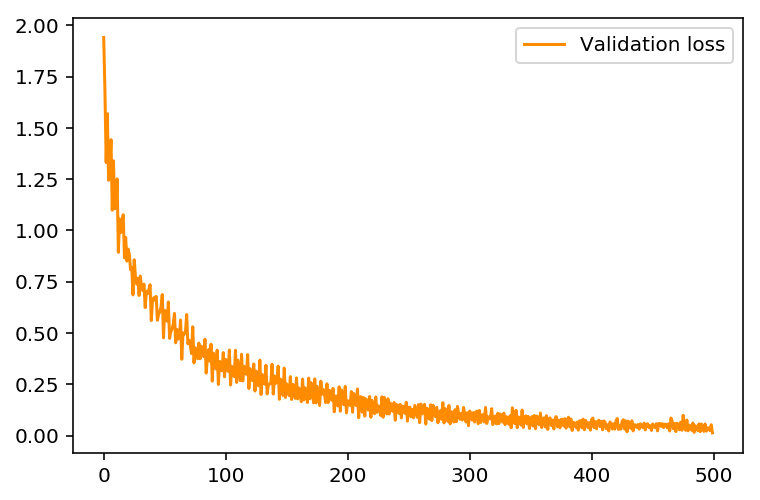

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(loss, label='Validation loss', color='darkorange')
plt.legend()
_ = plt.ylim()

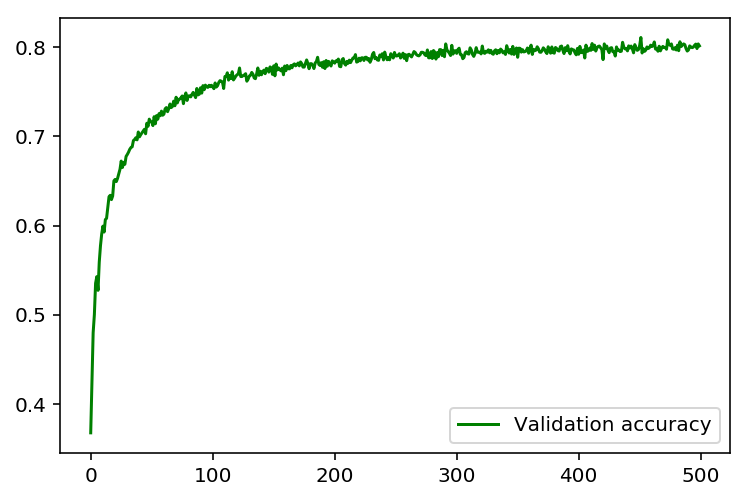

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(acc, label='Validation accuracy', color='green')
plt.legend()
_ = plt.ylim()

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification_Selu
Testing Accuracy: 0.7902492088607594



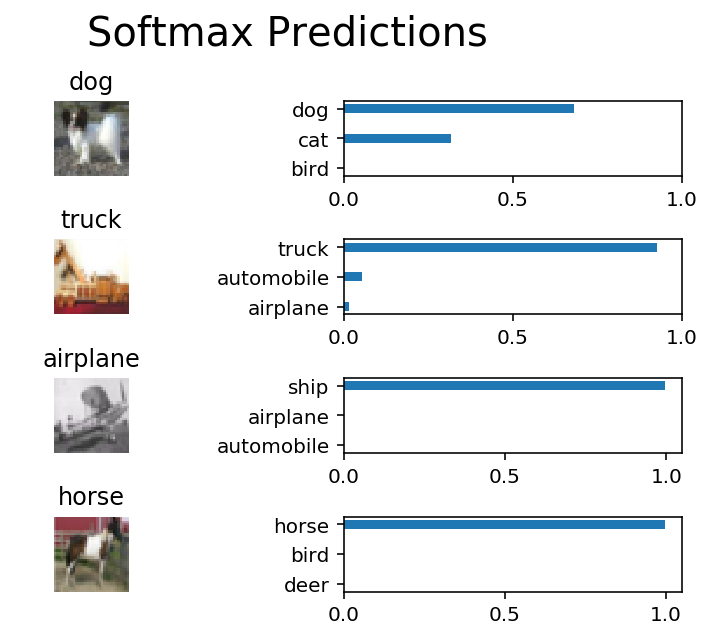

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification_Selu'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(config=config, graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, you might notice people are getting scores [well above 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't taught you all there is to know about neural networks. We still need to cover a few more techniques.
## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "dlnd_image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.

Some ideas

- Initialize weights to very small
- Initialize biases to zeros

### Bonus: let accuracy over 80%
- Differntial Dropout: keep probability
- Xavier Initialization → He Initialization
- Batch Normalization
- Random Shuffling
- L2
- Selu